# 목적
* 블로그 내용을 긁어와서 연관분석 진행
1. keyword관련 블로그 크롤링 
    정확도 기준으로 긁어오되 날짜도 같이 가져와서 나중 어떤 날짜에 집중되어 있는지 확인  
    한 블로그당 단어빈도수 분석(필요할까)
2. 블로그 내 단어 토크나이즈하고 
3. 연관분석실시


# 선행설치

In [19]:
# 선행설치
# # 크롤링
# !pip install beautifulsoup4
# !pip install requests
# !pip install lxm
# # 연관분석
# !pip install apyori
# # 자연어처리
# !pip install konlpy (JDK 설치가 되어있어야함 )
# # 워드클라우드
# !pip install wordcloud

In [20]:
# import
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook  # 진행과정 시각화
from datetime import timedelta  # 시간날짜
from apyori import apriori  # 연관분석

import re
import json
import math
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np

import requests
import urllib.request
import urllib.error
import urllib.parse
from bs4 import BeautifulSoup  # 크롤링

import wordcloud
import konlpy
from konlpy.tag import Komoran,Kkma,Okt,Twitter  # 자연어처리
from eunjeon import Mecab #은전한닢
mecab = Mecab()
komoran = Komoran(userdic='./user_dictionary.txt')

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important; }</style>'))

# 네이버 검색 URl구조

date_from - YYYYMMDD : 시작날짜 date_option 8일때   
date_option - int : 0 : 전체, 2 : 1일, 3 : 1주, 4 : 1개월, 6 : 6개월, 7 : 1년, 8 : 기간지정  
date_to - YYYYMMDD : 마지막날짜 date_option 8일때  
dup_remove - int : 유사문서제거옵션 1 : 제거, 0 : 유지  
nso - str : _상세검색으로 추정_   
post_blogurl - ?  
post_blogurl_without - ?   
query - str : 검색어     
sm=tab_pge -?    
st - str : 정렬순서 sim : 유사도 date : 날짜    

In [21]:
# #네이버에서 검색했을때 url구조
# https://search.naver.com/search.naver
#     ?date_from=&
#     date_option=0&
#     date_to=&
#     dup_remove=1&
#     nso=&
#     post_blogurl=
#     &post_blogurl_without=
#     &query=%EC%96%91%EC%96%91
#     &sm=tab_pge
#     &srchby=all
#     &st=sim
#     &where=post
#     &start=11

In [22]:
def del_outword(string):
    '''
    이모티콘, \u200b과 같은 문자가 아닌 것 제거
    #이모티콘 제거 [출처](https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
    '''
    #이모지제거
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~"^_\n\r#\ufeff\u200d\u200b\u7643\ufffd\u682e\u62c4]+')
    
    string = emoji_pattern.sub(r'',string)
    string = han.sub(r'',string)
    
    return string

In [23]:
def time_change(x):
    '''
    검색결과에 있는 문자를 날짜로 변경
    '''
    min_pattern = re.compile('[0-9]+'+"분 전")
    hour_pattern = re.compile('[0-9]+'+"시간 전")
    day_pattern = re.compile('[0-9]+'+"일 전")

    today = datetime.datetime.today().date()
    # 일자
    try:
        d = re.findall(day_pattern, x)[0][0]
        x = today - timedelta(days=int(d))
    except:
        pass
    # 시간
    try:
        d = re.findall(hour_pattern, x)[0]
        x = today
    except:
        pass
    # 분
    try:
        h = re.findall(min_pattern, x)[0]
        x = today
    except:
        pass

    if x == '어제':
        x = today - timedelta(days=1)

    elif type(x) == str:
        x = datetime.datetime.strptime(x.replace('.', '-')[:-1], '%Y-%m-%d')
    #모든일자를 1일로 통일
    x = datetime.datetime.strptime(x.strftime('%Y-%m')+"-01","%Y-%m-%d")
    return x

In [30]:
def naver_blog_crawling(keyword, start_num=1, end_num=101, date_option=0, date_from='', date_to='', save=True):
    '''
    네이버 블로그 크롤링 함수
    네이버 블로그 검색결과를 크롤링하며, 1페이지당 10개씩을 검색한다

    keyword : string
     검색하고 싶은 키워드를 넣는다
     "keyword +필수어" 형태로 필수단어 추가 가능
    start_num : int (default = 1) 
     시작할 위치 1로 끝나는 단위 추천
    end_num : int (default = 101)
     끝나는 위치 1로 끝나는 단위 추천
    date_option : int (default = 0)
     주어지는 숫자에 의해 검색방법이 변경됨
     0 : 전체, 2 : 1일, 3 : 1주, 4 : 1개월, 6 : 6개월, 7 : 1년, 8 : 기간지정
    date_from : YYYYMMDD (default = "")
     date_option이 8일때 사용 검색 시작일자를 지정
    date_to : YYYMMDD (default = "")
     date_option이 8일때 사용 검색 마지막일자를 지정
    save : bool (default = True)
     csv로 저장 여부 결정
    '''
    # url 찾는 패턴
    pattern = re.compile('href="'+'[A-z0-9\:\/\&\;\.\?\=]+')

    # 저장위치
    postdates = []
    strings = []
    urls = []
    titles = []
    output_error = []
    connection_error = []
    count = 1
    base_url_ls = []

    # keyword와 시작넘버만 바꾸면서 진행하게끔
    base_url = 'https://search.naver.com/search.naver?date_from={date_from}&date_option={date_option}&date_to={date_to}&dup_remove=1&nso=&post_blogurl=&post_blogurl_without=&query={keyword}&sm=tab_pge&srchby=all&st=sim&where=post&start={start}'

    # for문 돌려야하는 부분(각 검색결과의 시작은 1이고, 10개씩 보여짐,)
    for i in tqdm_notebook(range(start_num, end_num+1, 10), desc="page work"):
        search_list = base_url.format(keyword=keyword, start=i,
                                      date_option=date_option, date_from=date_from, date_to=date_to)
        response = requests.get(search_list)
        base_url_ls.append(search_list)
        if response.status_code is 200:
            # 1번 검색시 10개의 결과가 출력 따라서 section은 총 10개
            soup = BeautifulSoup(response.content, 'lxml')
            sections = soup.findAll('li', attrs={'class': 'sh_blog_top'})

            for section in sections:
                try:
                    # href부분만 가져오기 어려워서 정규표현식으로 검색
                    url = re.findall(pattern, str(section))[0].replace(
                        '?Redirect=Log&amp;logNo=', '/').replace('href="', '')
                    title = section.select_one('a.txt84').text
                    date = section.select_one('dd.txt_inline').text.strip()

                    # 블로그 url안에 들어가기(아직 크롤링불가)
                    get_blog_post_content_code = requests.get(url)
                    get_blog_post_content_text = get_blog_post_content_code.text
                    get_blog_post_content_soup = BeautifulSoup(
                        get_blog_post_content_text, 'lxml')

                    # 크롤링가능한 url에 접속
                    real_blog_post_url = "http://blog.naver.com" + \
                        get_blog_post_content_soup.select('#mainFrame')[
                            0].get('src')
                    get_real_blog_post_content_code = requests.get(
                        real_blog_post_url)
                    get_real_blog_post_content_text = get_real_blog_post_content_code.text
                    get_real_blog_post_content_soup = BeautifulSoup(
                        get_real_blog_post_content_text, 'lxml')

                    # url (에러나면 위에서부터 에러남)
                    urls.append(real_blog_post_url)
                    # 블로그명
                    titles.append(title)
                    # 날짜
                    postdates.append(date)

                    # 본문  (postviewarea 패턴과 se-main-container 2가지 유형이 있어 분리함)
                    try:
                        blog_post_content = get_real_blog_post_content_soup.select(
                            'div#postViewArea')
                        if len(blog_post_content) == 0:
                            blog_post_content = get_real_blog_post_content_soup.select(
                                'div.se-main-container')
                            if len(blog_post_content) == 0:
                                blog_post_content = get_real_blog_post_content_soup.select(
                                    'div.se_component_wrap.sect_dsc.__se_component_area')

                        string = ""
                        for sentence in blog_post_content[0].stripped_strings:
                            string += " "+sentence.replace('\xa0', " ")
                        # 비언어 텍스트제거
                        string = del_outword(string)
                        strings.append([string])
                        count += 1
                    except:
                        strings.append(["X"])
                        count += 1

                except Exception as ex:
                    # print('가져오기에러 {num}번째'.format(num = count),ex)
                    output_error.append(count)
                    count += 1
                    pass
        else:
            # print('연결오류 {num}번째'.format(num = count),response.status_code)
            connection_error.append(count)
            count += 1

    out_length = len(output_error+connection_error)
#     real_length = end_num-start_num+10-out_length
    crawling_df = pd.DataFrame(
        {"post_dates": postdates, "title": titles, "full_text": strings, "url": urls})
    crawling_df['post_dates'] = crawling_df['post_dates'].apply(
        lambda x: time_change(x))

    # 중복제거
    crawling_df.drop_duplicates("url", inplace=True)
    crawling_df.reset_index(drop=True, inplace=True)
    real_length = crawling_df.shape[0]

    # 결과출력
    print("검색한 길이:", end_num-start_num+10)
    print("제외된 길이:", out_length)
    print("검색된 길이:", real_length)
    if save == True:
        today = datetime.datetime.today().date()
        str(today)
        crawling_df.to_csv(str(today)+"_"+keyword+"_" +
                           str(real_length)+'.csv', encoding='utf-8', index=False)
    return crawling_df, output_error, real_length

In [383]:
# keyword검색시 "검색어 +필수어" 형태로 필수단어 삽입가능
today = datetime.datetime.today().date()
keyword = "설악해수욕장 +양양"
start_num = 1
end_num = 701
date_option = 0
date_from = "20150101"
date_to = "20190101"

In [384]:
crawling_df, output_error, real_length = naver_blog_crawling(keyword, start_num, end_num, date_option, date_from, date_to, save=False)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



검색한 길이: 710
제외된 길이: 106
검색된 길이: 604


### 추출된 데이터 일자별 집중도 확인

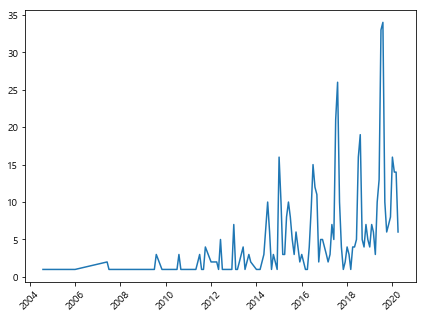

In [385]:
plt.figure(figsize=(7,5))
plt.plot(crawling_df['post_dates'].value_counts().sort_index())
plt.xticks(rotation = 45)
# plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_날짜빈도'+'.png')
plt.show()

### 토크나이즈

### 형용사 - 연구중 2020-04-06 13:03:43 
* 각 형태소 분석기 비교
1. komoran/mecab 어간/어미를 분해해서 다소 카운팅하기 어려움
2. okt adjective로 되어있어 다소 편리하면서 더 많은 형용사를 끌어옴

In [378]:
all_va = []
VA_ls = []

sw = list(set(['오늘', '시간', '최근', '지난', '관련', '이번', '이날', '현재', '10', '올해', '지난해', '있다', '이상', '기준', '때문',
               "메뉴", "주문", "강원도", '정도', '도착', '생각', '양양군', '사진', '위치', '라고', '양양', "아침", "저녁", '다음', '우리', '시작', '여기', '이곳', '사람',
              "이다", "많다","좋다","같다","없다","그렇다","이렇다","아니다","안녕하다","가능하다"]))

for i in tqdm_notebook(range(0,len(crawling_df))):
    VA_ls = []
    #어근만 추출
    pos_text = okt.pos(crawling_df['full_text'][i][0], norm=True, stem=True)
    for j in range(0,len(pos_text)):
        if pos_text[j][1] == 'Adjective':
            text = pos_text[j][0]
            VA_ls.append(text)
    clean_va = list(filter(lambda word : (len(word)>1)&(word not in sw),VA_ls))
    clean_va = list(set(clean_va))
    all_va.append(clean_va)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [379]:
all_va_flatten = [y for x in all_va for y in x]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

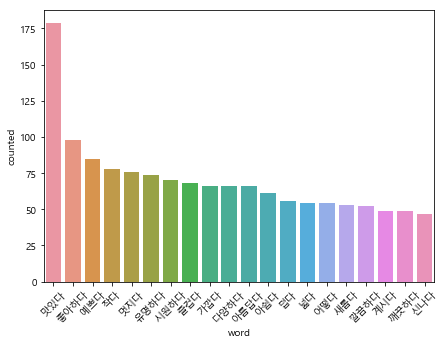

In [380]:
count_df = pd.Series(all_va_flatten).value_counts().reset_index()

count_df.columns = ['word','counted']

plt.figure(figsize=(7,5))
sns.barplot(x= 'word', y = 'counted', data = count_df.head(20))
plt.xticks(rotation = 45)

In [382]:
count_df.head(30)

,word,counted
0,맛있다,179
1,좋아하다,98
2,예쁘다,85
3,작다,78
4,멋지다,76
5,유명하다,74
6,시원하다,70
7,즐겁다,68
8,가깝다,66
9,다양하다,66


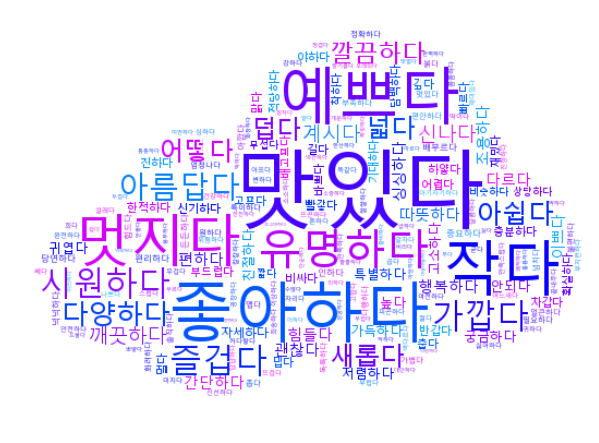

In [381]:
#워드클라우드

#마스킹 준비
from PIL import Image
import numpy as np
import wordcloud
import random

img_path = "vector-cloud-png.png"
img = Image.open(img_path).convert('RGBA')
mask = Image.new("RGB", img.size, (255,255,255))
mask.paste(img, img)
mask = np.array(mask)

text= ' '.join(all_va_flatten)

wordc = wordcloud.WordCloud(background_color = 'White', max_words= 200,
                           font_path = 'C:/Windows/Fonts/malgun.ttf',
                           relative_scaling = 0.5,
                           stopwords= sw,
                           collocations = False,
                        mask = mask)
wordc.generate(text)

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(%d,100%%,50%%)' % random.randint(200,300) #색상 채도 밝기
wordc.recolor(color_func = grey_color, random_state =3)

#그리기
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(wordc, interpolation = 'bilinear')
#저장
plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_워드클라우드'+'.png')
plt.show()

### 결과에 대한 의문

In [367]:
word_check_ls = []
for i in range(0, len(all_va)):
    if "가능하다" in all_va[i]:
        word_check_ls.append(i)

In [368]:
word_check_ls[:5]

[2, 7, 8, 13, 37]

In [370]:
crawling_df['full_text'][7][0]

" 서핑 타는 법 처음 배움 양양 서핑스팟 인구해수욕장에서 서핑을 강원도 바닷가 여태까지 강릉 쪽 경포대 해수욕장만 좋은 줄 알았는데, 서핑으로 핫한 양양을 알게 된 지는 얼마 되지 않았답니다. 저는 서핑을 사실 친구들이 가자가 자 해서 갔던 케이스인데요 여름엔 바다보다는 시원한 계곡을 좋아하고 땡볕에서 운동하는 거 별로 좋아하지 않는 사람이라서요 그런데 요즘 서핑이 그렇게 재미나다며 친구들이 가자고 하길래 서핑을 알아보았습니다. 수많은 서핑샵이 즐비한 양양 쪽 해수욕장 블로거가 또 블로그를 보며 정보를 수집하는 와중에 게스트하우스에서 보통 서핑도 가르치더라고요 (게하에서하는 서핑샵이름이 양양 서핑스팟임) 서핑 강습과 숙박 그리고 바비큐 파티를 한꺼번에 가능한 인구 해수욕장 앞,  서핑스팟 에 다녀왔습니다. ◆양양 서핑하러 가는법◆ 서울에서 양양 가는 것도 양양 고속도로가 뚫렸다곤 하지만 꽤나 오랜 시간이 걸려요 사실 동서울 버스터미널 ->양양 3시간 걸리고요 양양에서 택시로는 20분 (택시비 2만 원) 시내버스로는 1시간 (약 4천 원)의 교통비가 듭니다. 갈 때 편도만 택시비 뿜빠이 한다고 치더라도 서울에서 시외버스+ 양양에서 서핑샵까지 2만원 중반대의 교통비가 들어요 그러나 저는 럭키하게도 공휴일에 방문해서 셔틀버스 타고 게스트하우스 앞에 바로 내렸기 때문에 편하게 갔답니다 셔틀비용 편도 18000원 왕복 3만 원 양양 가는 법은 나중에 따로 포스팅을 해야 할 것 같아요 서핑타는곳 인구해수욕장은  양양 시외버스터미널로 가도 되고 강릉 터미널 주문진 터미널 어디에서나 비슷한 거리에 있었거든요 보통 강릉 터미널에서도 많이 옵니다 ktx도 있어서요 가는 거조차 귀찮았던 양양 서핑 과연 즐거웠을까요 안 즐거웠으면 포스팅도 안 합니다  사실 너무 꿀 잼이었거든요 서핑 강습은 이론교육 30분 지상 교육 잘할때까지 (20분정도) 실전교육 약 1시간 자유시간으로 이뤄져 있답니다. 솔게하에서 교육을 받고 짐을 맡기고 서핑 연습할 준비를 합니다. 서핑 준비물은 저는 래시가

In [369]:
pos_text = okt.pos(crawling_df['full_text'][7][0], norm=True, stem=True)

### 함수화전

In [392]:
crawling_df['url'][440]

'http://blog.naver.com/PostView.nhn?blogId=wert11254e&logNo=221883656430&redirect=Dlog&widgetTypeCall=true&directAccess=false'

In [395]:
crawling_df['full_text'][441][0]

' 양양여행 / 양양호텔 : 투와이 호텔 후기 난생첨 하이와 둘이 떠단 양양 여행 @.@ 학기 끝나자 마자 떠나버렸어요 2016.07.262016.07.27 설악해수욕장에서 걸어서 2분거리인 투와이 호텔  신축한 호텔이라 완전 깨끗해요  인근에는 낙산사와 후진항활어회센터가 있어요. 도착한 투와이 호텔  위사진은 옆문이에요  저희는 양양 터미널에서 버스 (9번과 9-1번 둘다감)를 타고 왔어요 . 설악해수욕장 정류장에서 내려서 길건너면 바로있습니다. 버스도 15분에서 30분에 한대씩옵니다   신축한 호텔답게 깔끔한 양양호텔 투와이의 1층에는 퍼스트플로어라는 브런치카페겸 펍이 있어요 .  가격은 요러하니 투와이호텔 이용하실때 알아두세요   양양호텔 투와이호텔 층별 안내  복도도 깨끗   그리고 투와이호텔에서는 너무 좋은 향기가 나요   방에 들어서자 , 왼쪽에는 화장대와 오른쪽에는 화장실 그리고 바다전망의 룸  깨끗한 침대와 티테이블과 티비가 있네요  디럭스룸이라 디럭스 침대로 넓직하게 이불말아서 자는 하이와도 이불싸움 없이 잘 잤습니다   완전 뽀송뽀송한 호텔 침구 >.< 침대옆에는 콘센트로 네개나 넉넉히 있었어요 .  곧 짐을 널어놓게 될 티테이블  바다가 완전 잘 보였습니다  화장실도 깨끗  샤워부스가 있었구요 , 온수 빨리 잘나왔습니다   완전 넉넉한 수건들 ...  호텔 비품으로 샴푸 컨디셔너 바디워시에 바디로션까지  비누또한 준비되어있었고 , 그 외의 어메니티에는 샤워캡 칫솔2 화장솜+면봉+머리끈 .  앗 모르고 로고로 가려버렸지만, 원두 커피티백도 있었어요 .  네슬레 물도 두병 무료   화장대 밑에 헤어드라이어와 가운 슬리퍼있어요  꼼꼼히 다 갖추어져있더라구요 .    양양호텔 투와이에서 쾌적하게 지내시면 될거 같아요  당연히 에어컨과 티비도 완비   굴다리로 건너서 나가면 설악해수욕장이 바로 코앞  저희도 물놀이 하다가 호텔와서 편하게 씻고 아주 편리하게 이용했어요 . 설악해수욕장에는 사람이 그렇게 많은 것도 아니였고 , 물도 깨끗했고 해변도 아담

In [394]:
komoran.nouns(crawling_df['full_text'][441][0])

['양양',
 '여행',
 '양양',
 '호텔',
 '투',
 '와이',
 '호텔',
 '후기',
 '난생',
 '첨',
 '하이',
 '양양',
 '여행',
 '학기',
 '설악',
 '해수욕장',
 '분',
 '거리',
 '투',
 '와이',
 '호텔',
 '신축',
 '호텔',
 '완전',
 '인근',
 '낙산사',
 '후진항',
 '활어',
 '회',
 '센터',
 '도착',
 '투',
 '와이',
 '호텔',
 '위',
 '사진',
 '옆',
 '문',
 '양양',
 '터미널',
 '버스',
 '번',
 '-1',
 '번',
 '다감',
 '설악',
 '해수욕장',
 '정류장',
 '길',
 '버스',
 '분',
 '분',
 '한대',
 '신축',
 '호텔',
 '양양',
 '호텔',
 '투',
 '와이',
 '퍼스트',
 '플로어',
 '브런치',
 '카페',
 '겸',
 '가격',
 '러',
 '하니',
 '투',
 '와이',
 '호텔',
 '이용하',
 '실',
 '때',
 '양양',
 '호텔',
 '투',
 '와이',
 '호텔',
 '층',
 '안내',
 '복도',
 '투',
 '와이',
 '호텔',
 '향기',
 '방',
 '왼쪽',
 '화장대',
 '오른쪽',
 '화장실',
 '바다',
 '전망',
 '룸',
 '침대',
 '티',
 '테이블',
 '티',
 '비',
 '디',
 '럭스',
 '룸',
 '디',
 '럭스',
 '침대',
 '이불',
 '자',
 '하이',
 '와도',
 '이불',
 '싸움',
 '완전',
 '호텔',
 '침구',
 '침대',
 '옆',
 '콘센트',
 '개',
 '짐',
 '티',
 '테이블',
 '바다',
 '완전',
 '화장실',
 '샤워',
 '부스',
 '온수',
 '완전',
 '수건',
 '호텔',
 '비품',
 '샴푸',
 '바',
 '디워',
 '시',
 '바',
 '디',
 '로션',
 '비누',
 '준비',
 '외',
 '어메니티',
 '샤워',
 '캡',
 '칫솔',
 '화장',
 '솜',


In [413]:
crawling_df['url'][439]

'http://blog.naver.com/PostView.nhn?blogId=kjakfldh&logNo=221008785961&redirect=Dlog&widgetTypeCall=true&directAccess=false'

In [409]:
nouns = komoran.nouns(crawling_df['full_text'][438][0])

In [447]:
komoran

In [448]:
komoran = Komoran()

In [461]:
for i in tqdm_notebook(range(430,450)):
    tt = crawling_df['full_text'][i][0]
    komoran.pos(tt, flatten=True, join=True)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


java.lang.NullPointerException: java.lang.NullPointerException

In [452]:
unique = True

sw = list(set(['오늘','시간','최근','지난','관련','이번','이날','현재','10','올해','지난해','있다','이상','기준','때문',
     "메뉴","주문","강원도",'정도','도착','생각','양양군','사진','위치','라고','양양',"아침","저녁",'다음','우리','시작','여기','이곳','사람']))

all_nouns =[]

for i in tqdm_notebook(range(0,len(crawling_df))):
    nouns = komoran.nouns(crawling_df['full_text'][i][0])
    clean_nouns = list(filter(lambda word : (len(word)>1)&(word not in sw),nouns))
    if unique == True:
        clean_nouns = list(set(clean_nouns))
    all_nouns.append(clean_nouns)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


java.lang.NullPointerException: java.lang.NullPointerException

In [ ]:
#단어빈도분석 
#2중리스트 flatten
all_noun_flatten = [y for x in all_nouns for y in x]

count_df = pd.Series(all_noun_flatten).value_counts().reset_index()

count_df.columns = ['word','counted']

plt.figure(figsize=(7,5))
sns.barplot(x= 'word', y = 'counted', data = count_df.head(20))
plt.xticks(rotation = 45)
#저장
# count_df.to_csv("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_단어빈도'+'.csv',encoding ='cp949')
# plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_단어빈도'+'.png')
plt.show()

In [ ]:
#워드클라우드

#마스킹 준비
from PIL import Image
import numpy as np
import wordcloud
import random

img_path = "vector-cloud-png.png"
img = Image.open(img_path).convert('RGBA')
mask = Image.new("RGB", img.size, (255,255,255))
mask.paste(img, img)
mask = np.array(mask)

text= ' '.join(all_noun_flatten)

wordc = wordcloud.WordCloud(background_color = 'White', max_words= 200,
                           font_path = 'C:/Windows/Fonts/malgun.ttf',
                           relative_scaling = 0.5,
                           stopwords= sw,
                           collocations = False,
                        mask = mask)
wordc.generate(text)

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(%d,100%%,50%%)' % random.randint(200,300) #색상 채도 밝기
wordc.recolor(color_func = grey_color, random_state =3)

#그리기
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(wordc, interpolation = 'bilinear')
#저장
plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_워드클라우드'+'.png')
plt.show()

### 함수화

In [259]:
#형태소분석기 종류비교
mecab = Mecab()
komoran = Komoran(userdic='user_dictionary.txt')
kkma = Kkma()
okt = Okt()
twitter = Twitter()

C:\Users\User\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
Mecab()

In [251]:
def tokenaize(tagger, target, unique = False, save = True):
    sw = ['오늘','시간','최근','지난','관련','이번','이날','현재','10','올해','지난해','있다','이상','기준','때문',
     "메뉴","주문","강원도",'정도','도착','생각','양양군','사진','위치','라고']
    all_nouns =[]

    for i in tqdm_notebook(range(0,len(crawling_df))):
        nouns = tagger.nouns(target[i][0])
        clean_nouns = list(filter(lambda word : (len(word)>1)&(word not in sw),nouns))
        if unique == True:
            clean_nouns = list(set(clean_nouns))
        all_nouns.append(clean_nouns)
        
    #2중리스트 flatten
    all_noun_flatten = [y for x in all_nouns for y in x]

    count_df = pd.Series(all_noun_flatten).value_counts().reset_index()

    count_df.columns = ['word','counted']

    plt.figure(figsize=(7,5))
    sns.barplot(x= 'word', y = 'counted', data = count_df.head(20))
    plt.xticks(rotation = 45)
    if save == True:
        count_df.to_csv("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_단어빈도'+'.csv',encoding ='cp949')
        plt.savefig("./output/"+str(today)+"_"+keyword+"_"+str(real_length)+'_단어빈도'+'.png')
    plt.show()
    
    return all_nouns

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


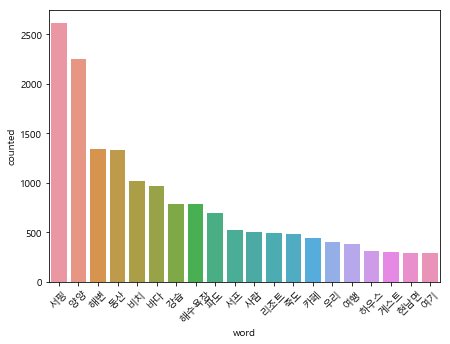

In [252]:
all_nouns = tokenaize(mecab,crawling_df['full_text'])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


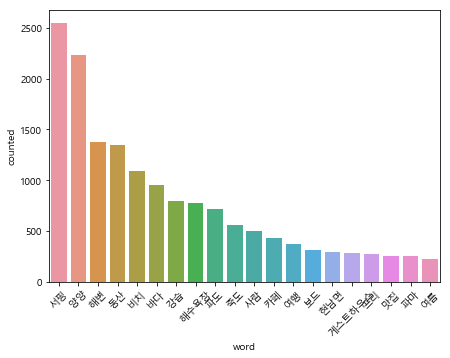

In [260]:
all_nouns = tokenaize(komoran,crawling_df['full_text'])

### 연관분석

In [75]:
noun_df = pd.DataFrame({'nouns':all_nouns})
rules = apriori(all_nouns, min_support=0.2, min_condience =0.3)
results  = list(rules)

In [81]:
results_df = pd.DataFrame(columns =["lhs",'rhs','support','confidence','lift'])
index =0
for row in results:   
    support = row[1]
    ordered_stat = row[2]
    for ordered_item in ordered_stat:
        lhs = " ".join(x for x in ordered_item[0])
        rhs = " ".join(x for x in ordered_item[1])
        confidence = ordered_item[2]
        lift = ordered_item[3]
        results_df.loc[index] = [lhs,rhs,support,confidence,lift]
        index = index +1

results_df = results_df.sort_values(by="lift",ascending=False)

In [82]:
results_df.head(20)

,lhs,rhs,support,confidence,lift
78,바다,해변,0.212379,0.413712,1.495168
79,해변,바다,0.212379,0.767544,1.495168
155,해변 양양,바다,0.211165,0.766520,1.493173
150,바다,양양 해변,0.211165,0.411348,1.493173
153,바다 양양,해변,0.211165,0.412322,1.490147
152,해변,바다 양양,0.211165,0.763158,1.490147
129,느낌,여행 양양,0.206311,0.669291,1.332116
134,여행 양양,느낌,0.206311,0.410628,1.332116
52,여행,느낌,0.206311,0.410628,1.332116
131,여행,느낌 양양,0.206311,0.410628,1.332116


In [83]:
results_df.tail(20)

,lhs,rhs,support,confidence,lift
89,,여행 사람,0.228155,0.228155,1.000000
119,,처음 양양,0.259709,0.259709,1.000000
50,,느낌 여행,0.206311,0.206311,1.000000
116,,준비 양양,0.211165,0.211165,1.000000
25,,준비,0.212379,0.212379,1.000000
26,,처음,0.260922,0.260922,1.000000
113,,양양 저녁,0.201456,0.201456,1.000000
110,,자리 양양,0.264563,0.264563,1.000000
27,,카페,0.248786,0.248786,1.000000
107,,이용 양양,0.200243,0.200243,1.000000


# 검수용코드

In [414]:
real_blog_post_url = 'http://blog.naver.com/PostView.nhn?blogId=kjakfldh&logNo=221008785961&redirect=Dlog&widgetTypeCall=true&directAccess=false'

In [415]:
get_real_blog_post_content_code = requests.get(real_blog_post_url)
get_real_blog_post_content_text = get_real_blog_post_content_code.text
get_real_blog_post_content_soup = BeautifulSoup(get_real_blog_post_content_text, 'lxml')

In [421]:
blog_post_content = get_real_blog_post_content_soup.select('div#postViewArea')
if len(blog_post_content) == 0:
    blog_post_content = get_real_blog_post_content_soup.select('div.se-main-container')
    if len(blog_post_content) == 0:
        blog_post_content = get_real_blog_post_content_soup.select('div.se_component_wrap.sect_dsc.__se_component_area')

In [423]:
string = ""
for sentence in blog_post_content[0].stripped_strings:
    string += " "+sentence.replace('\xa0', " ")

In [426]:
string

' 양양 투와이 호텔 이번에 속초여행때 숙박했던 투와이 호텔입니다. 속초에서도 그리 멀지 않은 곳에 있는 ㅎㅎ 투와이 호텔 위치는! 투와이호텔 강원도 양양군 강현면 동해대로 3277-3 투와이호텔 예약 전화 상세보기 <a onclick="return false;" href="#bSize" style="display:none" target="_blank" class="se_map_link __se_link" data-linktype="map" data-linkdata="{&quot;eventTarget&quot;:&quot;button&quot;,&quot;didSearch&quot;:&quot;true&quot;,&quot;searchEngine&quot;:&quot;NAVER&quot;,&quot;locationId&quot;:&quot;37815743&quot;,&quot;latitude&quot;:&quot;38.1317882&quot;,&quot;markerLatitude&quot;:&quot;38.1317882&quot;,&quot;markerLongitude&quot;:&quot;128.6207231&quot;,&quot;title&quot;:&quot;투와이호텔&quot;,&quot;longitude&quot;:&quot;128.6207231&quot;}">지도보기</a> 701호 코너 스위트로 예약을하고 체크인하고 들어가 봅니다 티브이도 있고 개인용품 키트도 준비되어 있습니다 침대가 두개~ 더블침대인듯?? 청소상태도 깔끔하고 좋았습니다 코너 스위트의 좋은 점은 바로 이렇게 바다가 바로 보인다는~~ 양야 앞바다가 보이네요~~ 저곳이 바로 설악해수욕장 깔끔한 화장실 비데도 있고~ 한쪽에는 샤워기도 있습니다 전반적으로 깔금한 투와이 호텔이네요 7층은 룸과 옆에 테라스바가 있는데 준비중인듯합니다 그런데 분위기는 정말 좋은~ 여기서 맥주 마시면 느낌있겠죠?? 여기서 전 일출을 봤습니다 바다에 나가지 않고 정말 편하게~~ HEAVEN IS HERE 건물 외

In [133]:
# 1개코드
# 저장위치
postdates = []
strings = []
urls = []
titles = []
output_error = []
connection_error = []
count = 1

pattern = re.compile('href="'+'[A-z0-9\:\/\&\;\.\?\=]+')
# keyword와 시작넘버만 바꾸면서 진행하게끔
base_url = 'https://search.naver.com/search.naver?date_from=&date_option=0&date_to=&dup_remove=1&nso=&post_blogurl=&post_blogurl_without=&query={keyword}&sm=tab_pge&srchby=all&st=sim&where=post&start={start_num}'

# for문 돌려야하는 부분(각 검색결과의 시작은 1이고, 10개씩 보여짐,)
search_list = base_url.format(keyword="전진리 +양양", start_num=13)
response = requests.get(search_list)

if response.status_code is 200:
    # 1번 검색시 10개의 결과가 출력 따라서 section은 총 10개
    soup = BeautifulSoup(response.content, 'lxml')
    sections = soup.findAll('li', attrs={'class': 'sh_blog_top'})
    section = sections[0]

    # href부분만 가져오기 어려워서 정규표현식으로 검색
    url = re.findall(pattern, str(section))[0].replace(
        '?Redirect=Log&amp;logNo=', '/').replace('href="', '')
    title = section.select_one('a.txt84').text
    date = section.select_one('dd.txt_inline').text.strip()

    # 블로그 url안에 들어가기(아직 크롤링불가)
    get_blog_post_content_code = requests.get(url)
    get_blog_post_content_text = get_blog_post_content_code.text
    get_blog_post_content_soup = BeautifulSoup(get_blog_post_content_text, 'lxml')

    # 크롤링가능한 url에 접속
    try:
        real_blog_post_url = "http://blog.naver.com" + \
        get_blog_post_content_soup.select('#mainFrame')[0].get('src')
        get_real_blog_post_content_code = requests.get(real_blog_post_url)
        get_real_blog_post_content_text = get_real_blog_post_content_code.text
        get_real_blog_post_content_soup = BeautifulSoup(
        get_real_blog_post_content_text, 'lxml')
    except:
        real_blog_post_url = url
        get_real_blog_post_content_code = requests.get(real_blog_post_url)
        get_real_blog_post_content_text = get_real_blog_post_content_code.text
        get_real_blog_post_content_soup = BeautifulSoup(
        get_real_blog_post_content_text, 'lxml')
        pass

    # url (에러나면 위에서부터 에러남)
    try:
        urls.append(real_blog_post_url)
    except:
        urls.append(url)
    # 블로그명
    titles.append(title)
    # 날짜
    postdates.append(date)

    # 본문  (postviewarea 패턴과 se-main-container 2가지 유형이 있어 분리함)
    try:
        blog_post_content = get_real_blog_post_content_soup.select('div#postViewArea')
        if len(blog_post_content) == 0:
            blog_post_content = get_real_blog_post_content_soup.select('div.se-main-container')
            if len(blog_post_content) == 0:
                blog_post_content = get_real_blog_post_content_soup.select('div.se_component_wrap.sect_dsc.__se_component_area')

        string = ""
        for sentence in blog_post_content[0].stripped_strings:
            string += " "+sentence.replace('\xa0', " ")

        strings.append([string])
        count += 1
    except:
        strings.append([np.NaN])
        count += 1


crawling_df = pd.DataFrame(
    {"post_dates": postdates, "title": titles, "full_text": strings, "url": urls})

In [138]:
blog_post_content = get_real_blog_post_content_soup.select('div#postViewArea')
if len(blog_post_content) == 0:
    blog_post_content = get_real_blog_post_content_soup.select('div.se-main-container')
    if len(blog_post_content) == 0:
        blog_post_content = get_real_blog_post_content_soup.select('div.se_component_wrap.sect_dsc.__se_component_area')

string = ""
for sentence in blog_post_content[0].stripped_strings:
    string += " "+sentence.replace('\xa0'," ")

strings.append([string])
count += 1

IndexError: list index out of range

# 발생한 오류

### 2020-04-06 09:23:51 크롤링중복오류 -> 1000개는 힘들다
* 약 600번대 이상부터 중복이 발생하는 것으로 보임
* 기사문 +양양 약 178개 중복
* 광진 +양양 약 215개 중복  

-> 원인은 네이버 검색의 특성상 관련검색어가 부족하면 중복되어서 나오는듯함
211번대와 161번대의 검색된 값이 유사함 

https://search.naver.com/search.naver?date_from=20190304&date_option=8&date_to=20200406&dup_remove=1&nso=p%3Afrom20190304to20200406&post_blogurl=&post_blogurl_without=&query=%EA%B4%91%EC%A7%84%20%2B%EC%96%91%EC%96%91&sm=tab_pge&srchby=all&st=sim&where=post&start=161

https://search.naver.com/search.naver?date_from=20190304&date_option=8&date_to=20200406&dup_remove=1&nso=p%3Afrom20190304to20200406&post_blogurl=&post_blogurl_without=&query=%EA%B4%91%EC%A7%84%20%2B%EC%96%91%EC%96%91&sm=tab_pge&srchby=all&st=sim&where=post&start=211

### 형용사 -개발단위
* 각 형태소 분석기 비교
1. komoran/mecab 어간/어미를 분해해서 다소 카운팅하기 어려움
2. okt adjective로 되어있어 다소 편리하면서 더 많은 형용사를 끌어옴

In [178]:
pos_df = pd.DataFrame()
va_df = pd.DataFrame()

In [179]:
okt = Okt()

In [187]:
#단하나 
VA_ls = []
pattern = re.compile("VA[+A-z]*")

pos_text = okt.pos(crawling_df['full_text'][1][0])
for i in range(0,len(pos_text)):
    try:
        re.search(pattern,pos_text[i][1]).group()
        text = pos_text[i][0]
        VA_ls.append(text)
    except: 
        pass

In [190]:
#okt 별도 
VA_ls = []
for i in range(0,len(pos_text)):
    if pos_text[i][1] == 'Adjective':
        text = pos_text[i][0]
        VA_ls.append(text)

In [192]:
va_df = pd.concat([va_df,pd.Series(list(set(VA_ls)))],axis = 1)

In [194]:
va_df.to_csv('va_df.csv',encoding='cp949')

In [154]:
pos_df = pd.concat([pos_df,pd.DataFrame(pos_text)],axis =1)

In [155]:
pos_df

,0,1,0,1,0,1
0,홍,NNP,홍천,NNG,홍천,Noun
1,천,NNP,에서,JKB,에서,Josa
2,에서,JKB,양양,NNP,양양,Noun
3,양양,NNP,으로,JKB,으로,Josa
4,으로,JKB,출발,NNG,출발,Noun
...,...,...,...,...,...,...
996,치,XSN,NaN,NaN,NaN,NaN
997,리,NNB,NaN,NaN,NaN,NaN
998,7,SN,NaN,NaN,NaN,NaN
999,-,SW,NaN,NaN,NaN,NaN


In [156]:
pos_df.to_csv('pos_df.csv',encoding = 'cp949')

In [129]:
#단하나 mecab
VA_ls = []
pattern = re.compile("VA[+A-z]*")

pos_text = mecab.pos(crawling_df['full_text'][1][0])
for i in range(0,len(pos_text)):
    try:
        re.search(pattern,pos_text[i][1]).group()
        text = pos_text[i][0]
        VA_ls.append(text)
    except: 
        pass